In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


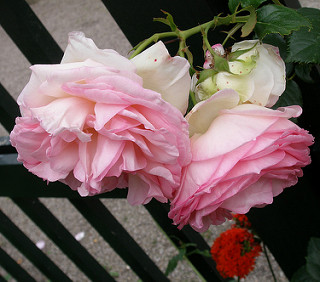

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

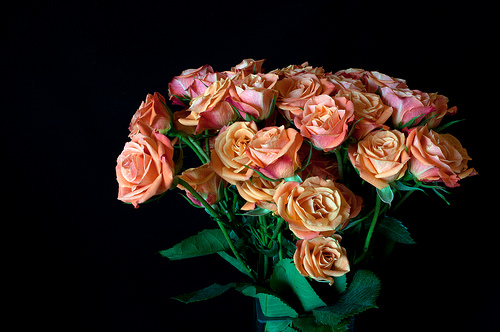

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[333]))

In [11]:
batch_size = 32
img_height =180
img_width = 180

In [12]:
#80% for training and 20% for validation(test)

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


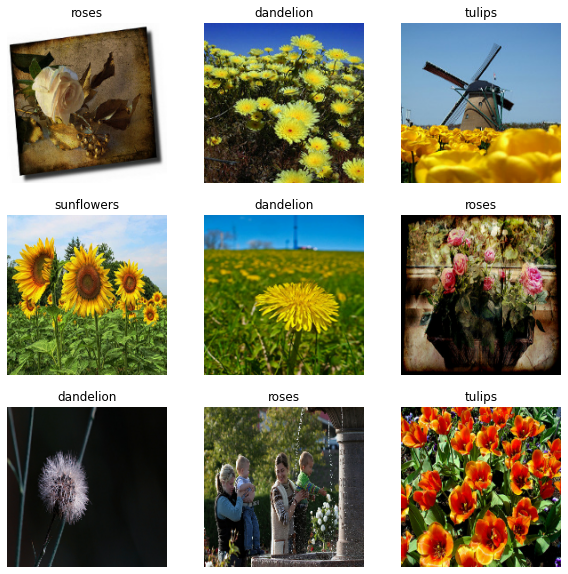

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [21]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 110s 1s/step - loss: 1.3492 - accuracy: 0.4002 - val_loss: 1.1489 - val_accuracy: 0.5286
Epoch 2/3
92/92 [==============================] - 106s 1s/step - loss: 1.0697 - accuracy: 0.5606 - val_loss: 1.0507 - val_accuracy: 0.5763
Epoch 3/3
92/92 [==============================] - 104s 1s/step - loss: 0.9068 - accuracy: 0.6505 - val_loss: 0.9302 - val_accuracy: 0.6471


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes)

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

b'/root/.keras/datasets/flower_photos/dandelion/463736819_f779800165.jpg'
b'/root/.keras/datasets/flower_photos/roses/2273917656_6d6c038283.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4805544785_a63241f6d0_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/6241886381_cc722785af.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13561912705_e5eeb41433_z.jpg'
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
2936
734
Image shape:  (180, 180, 3)
Label:  1
Epoch 1/3
92/92 [==============================] - 109s 1s/step - loss: 0.2284 - accuracy: 0.9278 - val_loss: 0.2352 - val_accuracy: 0.9169
Epoch 2/3
63/92 [===================>..........] - ETA: 30s - loss: 0.1140 - accuracy: 0.9643